In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Paths (relative to project root)
train_path = "./data/train_data_v2.csv"
test_path = "./data/test_data_v2.csv"
sample_path = "./sample/sample.csv"


In [2]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train shape: (14731, 22)
Test shape: (6599, 21)


,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,...,SearchEngine,Zone,Type of Traffic,CustomerType,Gender,Cookies Setting,Education,Marital Status,WeekendPurchase,Made_Purchase
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,1.0,9.0,3.0,Returning_Visitor,Not Specified,Deny,Not Specified,Other,0.0,False
1,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,2.0,2.0,4.0,Returning_Visitor,Female,Deny,Others,Married,0.0,False
2,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,3.0,1.0,4.0,Returning_Visitor,Female,ALL,Others,Married,1.0,False
3,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.4,...,4.0,3.0,3.0,Returning_Visitor,Male,ALL,Diploma,Single,0.0,False
4,1.0,0.0,0.0,0.0,0.0,0.000000,0.20,0.20,0.0,0.0,...,2.0,1.0,5.0,Returning_Visitor,Male,Deny,Diploma,Other,1.0,False


In [3]:
# Inspect columns and target
train_df.info()
print("\nMissing columns in test_df compared to train_df:")
print(set(train_df.columns) - set(test_df.columns))

print("\nValue counts (potential target columns):")
for col in train_df.columns[-5:]:
    print(f"\n{col}:")
    print(train_df[col].value_counts(dropna=False).head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14731 entries, 0 to 14730
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         14578 non-null  float64
 1   HomePage_Duration                14581 non-null  float64
 2   LandingPage                      14578 non-null  float64
 3   LandingPage_Duration             14596 non-null  float64
 4   ProductDescriptionPage           14608 non-null  float64
 5   ProductDescriptionPage_Duration  14564 non-null  float64
 6   GoogleMetric:Bounce Rates        14580 non-null  float64
 7   GoogleMetric:Exit Rates          14602 non-null  float64
 8   GoogleMetric:Page Values         14599 non-null  float64
 9   SeasonalPurchase                 14581 non-null  float64
 10  Month_SeasonalPurchase           14587 non-null  object 
 11  OS                               14597 non-null  float64
 12  SearchEngine      

In [4]:
# Drop rows with missing target just in case
train_df = train_df.dropna(subset=['Made_Purchase'])

# Separate features/target
X = train_df.drop('Made_Purchase', axis=1)
y = train_df['Made_Purchase']

# Fill numeric NaNs with median, categorical with mode
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].fillna(X[col].mode()[0])
    else:
        X[col] = X[col].fillna(X[col].median())

# Label encode categorical columns
from sklearn.preprocessing import LabelEncoder
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Confirm shape
print("Feature matrix:", X.shape)
print("Target distribution:")
print(y.value_counts())


Feature matrix: (14731, 21)
Target distribution:
Made_Purchase
False    9065
True     5666
Name: count, dtype: int64


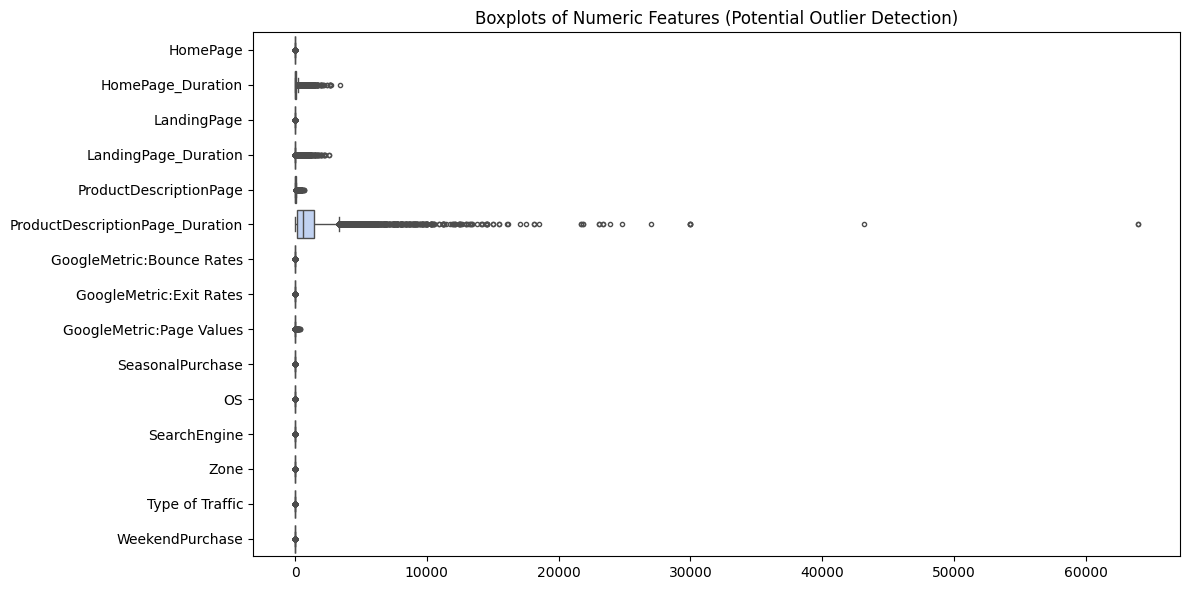

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assume df is your main dataset
num_cols = train_df.select_dtypes(include="number").columns

plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df[num_cols], orient="h", fliersize=3, palette="coolwarm")
plt.title("Boxplots of Numeric Features (Potential Outlier Detection)")
plt.tight_layout()
plt.show()


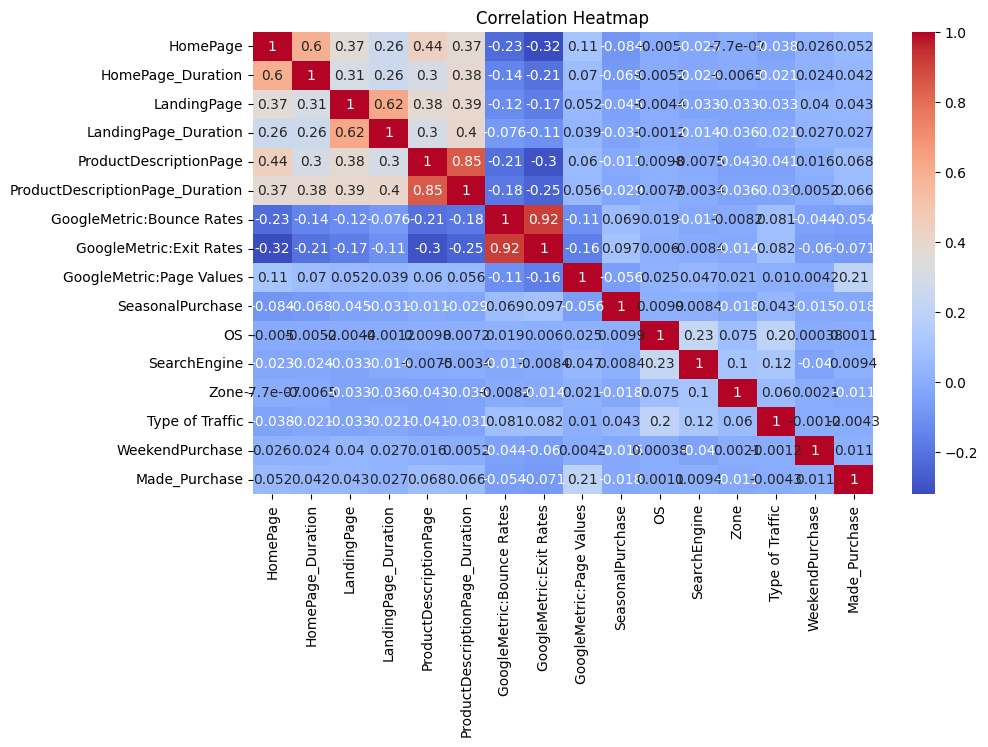

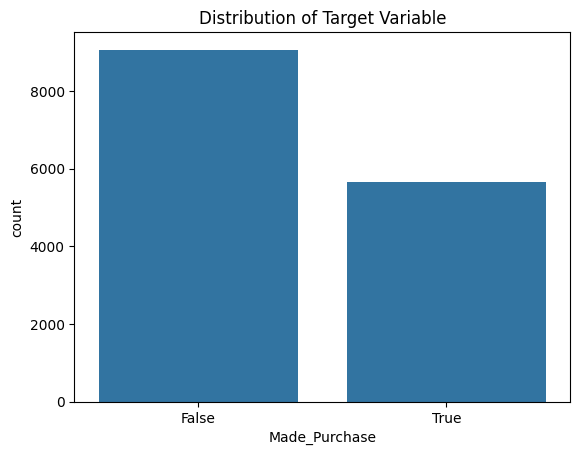

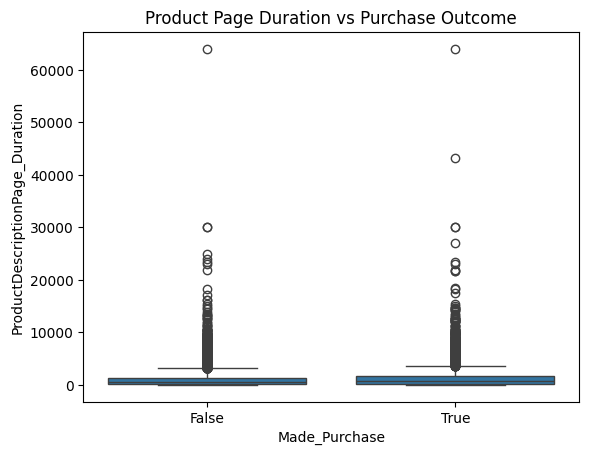

In [15]:
# 1. Summary statistics
train_df.describe(include="all").transpose()

# 2. Correlation heatmap for numeric features
plt.figure(figsize=(10,6))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 3. Target variable balance
sns.countplot(x='Made_Purchase', data=train_df)
plt.title("Distribution of Target Variable")
plt.show()

# 4. Example bivariate relationship
sns.boxplot(x='Made_Purchase', y='ProductDescriptionPage_Duration', data=train_df)
plt.title("Product Page Duration vs Purchase Outcome")
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 21)}
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
knn.fit(X_train_scaled, y_train)

print("Best K:", knn.best_params_)
print("Best CV accuracy:", knn.best_score_)

y_pred_knn = knn.predict(X_valid_scaled)
print("Validation accuracy:", accuracy_score(y_valid, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_knn))


Best K: {'n_neighbors': 20}
Best CV accuracy: 0.632213656823982
Validation accuracy: 0.6240244316253818

Classification Report:
               precision    recall  f1-score   support

       False       0.63      0.93      0.75      1813
        True       0.55      0.13      0.21      1134

    accuracy                           0.62      2947
   macro avg       0.59      0.53      0.48      2947
weighted avg       0.60      0.62      0.54      2947



Logistic Regression Accuracy: 0.6487953851374278

Classification Report:
               precision    recall  f1-score   support

       False       0.65      0.94      0.77      1813
        True       0.66      0.18      0.28      1134

    accuracy                           0.65      2947
   macro avg       0.65      0.56      0.53      2947
weighted avg       0.65      0.65      0.58      2947



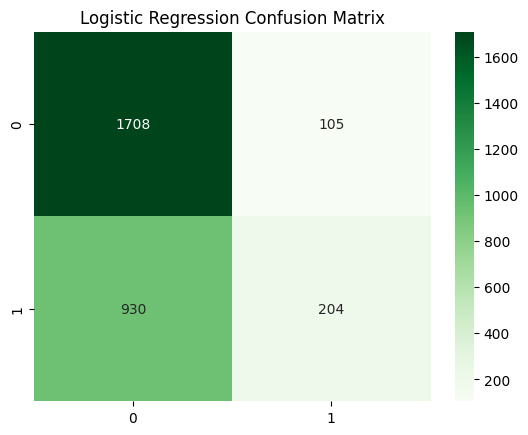

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_valid_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_valid, y_pred_log))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_log))

sns.heatmap(confusion_matrix(y_valid, y_pred_log), annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.show()


Balanced Logistic Regression Accuracy: 0.6437054631828979

Classification Report:
               precision    recall  f1-score   support

       False       0.67      0.83      0.74      1813
        True       0.56      0.35      0.43      1134

    accuracy                           0.64      2947
   macro avg       0.61      0.59      0.59      2947
weighted avg       0.63      0.64      0.62      2947



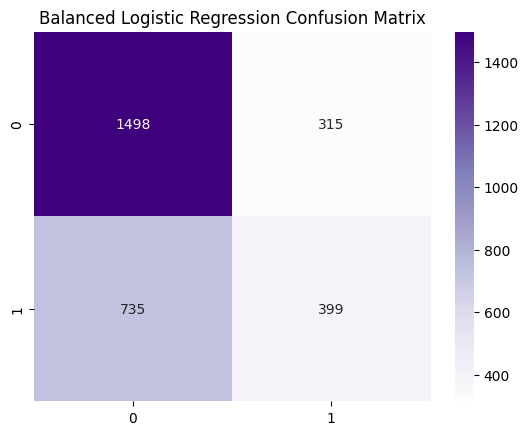

In [25]:
# Re-train logistic regression with class weights
log_reg_bal = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_bal.fit(X_train_scaled, y_train)

y_pred_bal = log_reg_bal.predict(X_valid_scaled)

print("Balanced Logistic Regression Accuracy:", accuracy_score(y_valid, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_bal))

sns.heatmap(confusion_matrix(y_valid, y_pred_bal), annot=True, fmt='d', cmap='Purples')
plt.title("Balanced Logistic Regression Confusion Matrix")
plt.show()


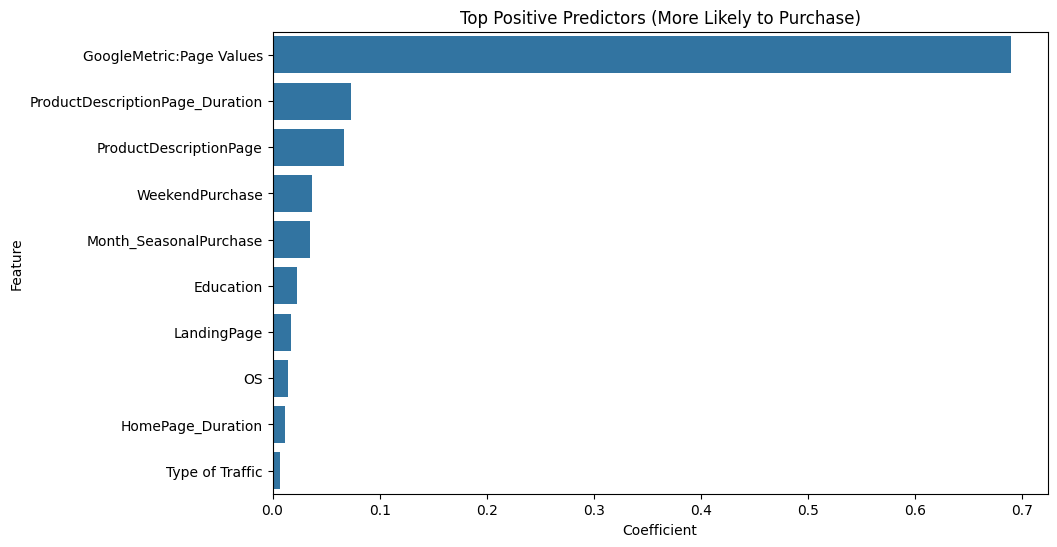

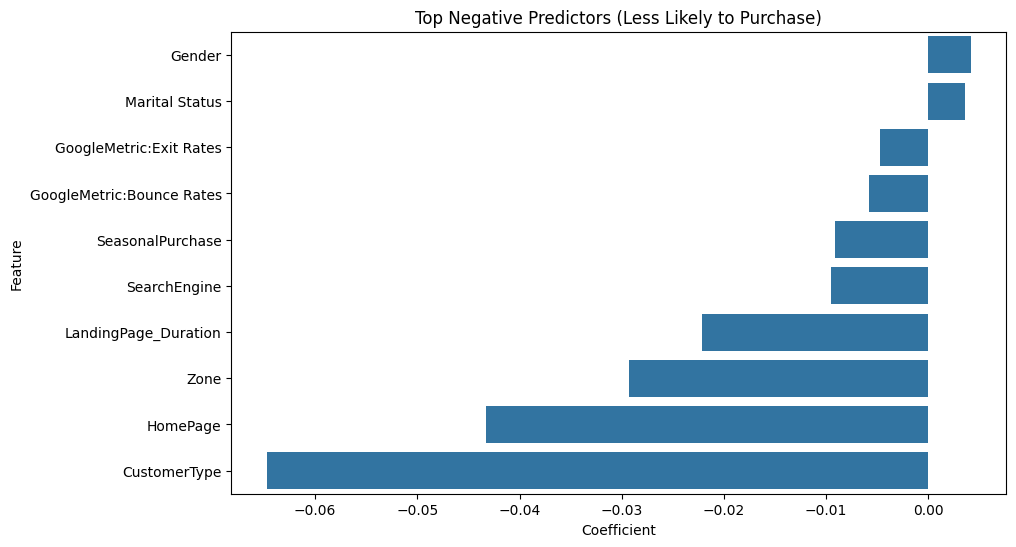

In [9]:
# Get and sort coefficients by absolute magnitude
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg_bal.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(10))
plt.title("Top Positive Predictors (More Likely to Purchase)")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.tail(10))
plt.title("Top Negative Predictors (Less Likely to Purchase)")
plt.show()


KNN ROC-AUC:                     0.5388
Logistic Regression ROC-AUC:     0.5963
Balanced Logistic ROC-AUC:       0.5971


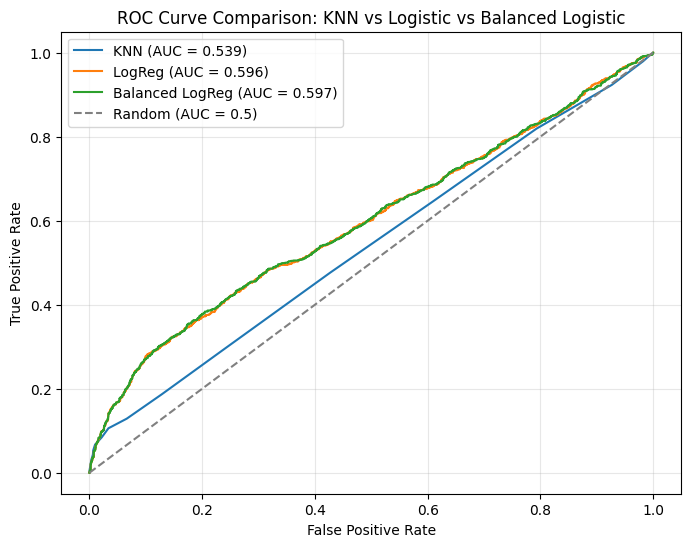

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- KNN ---
knn_probs = knn.predict_proba(X_valid_scaled)[:, 1]
knn_auc = roc_auc_score(y_valid, knn_probs)
fpr_knn, tpr_knn, _ = roc_curve(y_valid, knn_probs)

# --- Logistic Regression ---
log_probs = log_reg.predict_proba(X_valid_scaled)[:, 1]
log_auc = roc_auc_score(y_valid, log_probs)
fpr_log, tpr_log, _ = roc_curve(y_valid, log_probs)

# --- Balanced Logistic Regression ---
bal_probs = log_reg_bal.predict_proba(X_valid_scaled)[:, 1]
bal_auc = roc_auc_score(y_valid, bal_probs)
fpr_bal, tpr_bal, _ = roc_curve(y_valid, bal_probs)

# --- Print AUC scores ---
print(f"KNN ROC-AUC:                     {knn_auc:.4f}")
print(f"Logistic Regression ROC-AUC:     {log_auc:.4f}")
print(f"Balanced Logistic ROC-AUC:       {bal_auc:.4f}")

# --- Plot all on one figure ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {knn_auc:.3f})")
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUC = {log_auc:.3f})")
plt.plot(fpr_bal, tpr_bal, label=f"Balanced LogReg (AUC = {bal_auc:.3f})")

# random baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: KNN vs Logistic vs Balanced Logistic")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [11]:
from sklearn.preprocessing import LabelEncoder

# Make clean copies
train_simple = train_df.drop('Made_Purchase', axis=1).copy()
test_simple = test_df.copy()

# Fill missing values
for df in [train_simple, test_simple]:
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())

# Encode categorical columns safely
for col in train_simple.columns:
    if train_simple[col].dtype == 'object':
        le = LabelEncoder()
        combined_vals = pd.concat([train_simple[col].astype(str), test_simple[col].astype(str)], axis=0)
        le.fit(combined_vals)
        train_simple[col] = le.transform(train_simple[col].astype(str))
        test_simple[col] = le.transform(test_simple[col].astype(str))

# Make sure everything numeric
test_simple = test_simple.apply(pd.to_numeric, errors='coerce').fillna(0)

# Scale (using same scaler)
test_scaled = scaler.transform(test_simple)

# Predict with best model
preds = log_reg_bal.predict(test_scaled)

print("Example output:")
print(preds[:20])
print("Shape:", preds.shape)


Example output:
[False False False False False False False False False False False False
 False False False False False False False False]
Shape: (6599,)


In [12]:
# Compute validation accuracies directly
knn_val_acc = accuracy_score(y_valid, y_pred_knn)
log_val_acc = accuracy_score(y_valid, y_pred_log)
log_bal_val_acc = accuracy_score(y_valid, y_pred_bal)

# Combine into a summary table
results = pd.DataFrame({
    "Model": ["KNN (k=20)", "Logistic Regression", "Balanced Logistic Regression"],
    "Validation Accuracy": [knn_val_acc, log_val_acc, log_bal_val_acc],
    "Notes": [
        "Good baseline, weak recall for True class",
        "Slightly higher accuracy, better precision",
        "Lower accuracy but recall for True roughly doubled"
    ]
})

print("\n=== Model Performance Summary ===\n")
display(results)



=== Model Performance Summary ===



,Model,Validation Accuracy,Notes
0,KNN (k=20),0.626060,"Good baseline, weak recall for True class"
1,Logistic Regression,0.648795,"Slightly higher accuracy, better precision"
2,Balanced Logistic Regression,0.643705,Lower accuracy but recall for True roughly dou...


C:\Users\moohu\AppData\Local\Temp\ipykernel_21140\825321461.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x="Model", y="Validation Accuracy", palette="viridis")


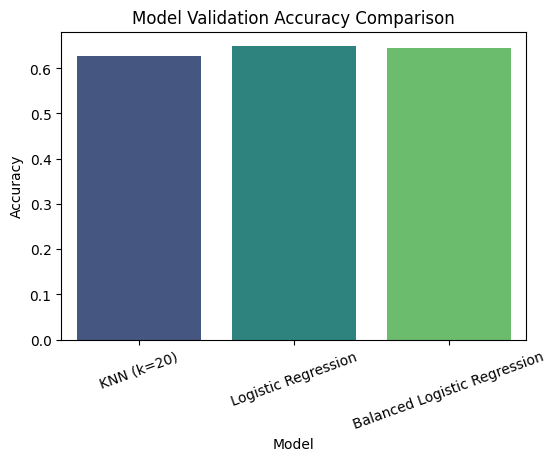

In [13]:
plt.figure(figsize=(6,4))
sns.barplot(data=results, x="Model", y="Validation Accuracy", palette="viridis")
plt.title("Model Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.show()


In [27]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

null_model = DummyClassifier(strategy='most_frequent')
null_model.fit(X_train_scaled, y_train)
null_preds = null_model.predict(X_valid_scaled)
null_probs = null_model.predict_proba(X_valid_scaled)[:,1]

print("Null model accuracy:", accuracy_score(y_valid, null_preds))
print("Null model ROC-AUC:", roc_auc_score(y_valid, null_probs))


Null model accuracy: 0.6152019002375297
Null model ROC-AUC: 0.5


In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

log_poly = LogisticRegression(max_iter=1000, random_state=42)
log_poly.fit(X_train_poly, y_train)

poly_auc = roc_auc_score(y_valid, log_poly.predict_proba(X_valid_poly)[:,1])
print(f"Logistic Regression with Interaction Terms ROC-AUC: {poly_auc:.4f}")


Logistic Regression with Interaction Terms ROC-AUC: 0.5785


In [32]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

# --- Create interaction-only polynomial features ---
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
feature_names = poly.get_feature_names_out(X_train.columns)

# --- Convert to DataFrame with matching index ---
X_train_poly_df = pd.DataFrame(X_train_poly, columns=feature_names, index=y_train.index)

# --- Add intercept and fit model ---
X_train_poly_df = sm.add_constant(X_train_poly_df)
logit_model = sm.Logit(y_train, X_train_poly_df)
result = logit_model.fit()

# --- View top 15 most significant terms ---
summary_table = result.summary2().tables[1]
print(summary_table.sort_values("P>|z|").head(15))


Optimization terminated successfully.
         Current function value: 0.624703
         Iterations 7
                                                       Coef.  Std.Err.  \
const                                              -0.528572  0.043425   
GoogleMetric:Page Values                            0.613917  0.089166   
HomePage GoogleMetric:Page Values                  -0.141238  0.041602   
GoogleMetric:Page Values SeasonalPurchase           0.269863  0.084904   
GoogleMetric:Page Values Month_SeasonalPurchase     0.104298  0.032849   
GoogleMetric:Bounce Rates GoogleMetric:Page Values -0.906002  0.288410   
HomePage Gender                                    -0.085556  0.029093   
Month_SeasonalPurchase                              0.068158  0.025811   
GoogleMetric:Page Values OS                        -0.086037  0.033262   
OS Education                                        0.054158  0.021778   
Month_SeasonalPurchase WeekendPurchase              0.046922  0.020985   
GoogleMetr

In [33]:
# Keep only significant features (p < 0.05)
significant_feats = summary_table[summary_table["P>|z|"] < 0.05].index

X_train_sig = X_train_poly_df[significant_feats]
logit_sig = sm.Logit(y_train, X_train_sig)
result_sig = logit_sig.fit()

print(result_sig.summary())


Optimization terminated successfully.
         Current function value: 0.633246
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Made_Purchase   No. Observations:                11784
Model:                          Logit   Df Residuals:                    11768
Method:                           MLE   Df Model:                           15
Date:                Mon, 27 Oct 2025   Pseudo R-squ.:                 0.04956
Time:                        10:39:18   Log-Likelihood:                -7462.2
converged:                       True   LL-Null:                       -7851.3
Covariance Type:            nonrobust   LLR p-value:                3.834e-156
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                       

In [36]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PolynomialFeatures

# 1. Rebuild the same interaction features on BOTH train and valid sets
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)
feature_names = poly.get_feature_names_out(X_train.columns)

X_train_poly_df = pd.DataFrame(X_train_poly, columns=feature_names, index=y_train.index)
X_valid_poly_df = pd.DataFrame(X_valid_poly, columns=feature_names)

# 2. Add constant column to both (this is critical for statsmodels)
X_train_poly_df_const = sm.add_constant(X_train_poly_df)
X_valid_poly_df_const = sm.add_constant(X_valid_poly_df)

# 3. Refit the full interaction model with statsmodels.Logit
logit_full = sm.Logit(y_train, X_train_poly_df_const)
full_result = logit_full.fit()

# 4. Build a reduced model with only significant predictors (p < 0.05)
summary_table = full_result.summary2().tables[1]
significant_feats = summary_table[summary_table["P>|z|"] < 0.05].index  # includes 'const' automatically

X_train_sig = X_train_poly_df_const[significant_feats]
reduced_model = sm.Logit(y_train, X_train_sig).fit()

# 5. IMPORTANT: build validation matrix with EXACT SAME COLUMNS and ORDER
X_valid_sig = X_valid_poly_df_const.reindex(columns=significant_feats, fill_value=0)

# 6. Get predicted probabilities on validation set from the reduced model
y_pred_sig = reduced_model.predict(X_valid_sig)

# 7. Compute ROC-AUC on validation labels
auc_sig = roc_auc_score(y_valid, y_pred_sig)
print(f"Reduced model ROC-AUC on validation: {auc_sig:.4f}")


Optimization terminated successfully.
         Current function value: 0.624703
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633246
         Iterations 7
Reduced model ROC-AUC on validation: 0.6027
